# Expression Classification Model Training (CNN)

This notebook demonstrates how to train a custom expression classification model (CNN) using TensorFlow and Keras, with CUDA support for GPU acceleration. The model will classify facial expressions into 7 categories: angry, disgust, fear, happy, neutral, sad, and surprise.

## instaling dependency

In [8]:
!pip install tensorflow[and-cuda] Keras NumPy Matplotlib Seaborn Scikit-learn

import and dependency call

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

## Data prepocessing

In [10]:
# Set up data paths and parameters
data_dir = './face-expression-recognition-dataset/images/images'
img_height, img_width = 48, 48
batch_size = 64
num_classes = 7

# Data preprocessing function
def preprocess_image(img):
    img = tf.cast(img, tf.float32)
    img = (img / 255.0) - 0.5
    return img

# Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

train_generator = train_datagen.flow_from_directory(
    f'{data_dir}/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    f'{data_dir}/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## CNN model settings

### definition

In [11]:
# CNN Model Definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

/opt/micromamba/envs/python_310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### model compiler

In [21]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Callbacks
checkpoint = ModelCheckpoint('./models/best_cnn_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 556,519 (2.12 MB)

 Trainable params: 554,599 (2.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

### train model

In [14]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=(train_generator.samples + batch_size - 1) // batch_size,  # Rounding up to include all data
    epochs=77,
    validation_data=validation_generator,
    validation_steps=max(1, validation_generator.samples // batch_size),  # Ensure at least 1 validation step
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weight_dict,
    shuffle=True
)

Epoch 1/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 127s 278ms/step - accuracy: 0.2005 - loss: 1.9220 - val_accuracy: 0.2831 - val_loss: 1.8077 - learning_rate: 0.0010
Epoch 2/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7692 - val_loss: 0.9403 - learning_rate: 0.0010
Epoch 3/77


2024-08-31 18:31:20.209603: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-31 18:31:20.209639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7584988788996885934
2024-08-31 18:31:20.209663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13964015377898620788


451/451 ━━━━━━━━━━━━━━━━━━━━ 135s 296ms/step - accuracy: 0.2260 - loss: 1.8938 - val_accuracy: 0.2855 - val_loss: 1.7742 - learning_rate: 0.0010
Epoch 4/77


2024-08-31 18:33:35.445929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14258754779561394531
2024-08-31 18:33:35.445965: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7584988788996885934
2024-08-31 18:33:35.445976: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13964015377898620788


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8846 - val_loss: 0.6187 - learning_rate: 0.0010
Epoch 5/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 140s 306ms/step - accuracy: 0.2436 - loss: 1.8381 - val_accuracy: 0.2946 - val_loss: 1.7202 - learning_rate: 0.0010
Epoch 6/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7308 - val_loss: 0.9295 - learning_rate: 0.0010
Epoch 7/77


2024-08-31 18:35:55.573274: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7584988788996885934
2024-08-31 18:35:55.573306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13964015377898620788


451/451 ━━━━━━━━━━━━━━━━━━━━ 134s 295ms/step - accuracy: 0.2733 - loss: 1.7979 - val_accuracy: 0.3055 - val_loss: 1.7332 - learning_rate: 0.0010
Epoch 8/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8462 - val_loss: 0.6016 - learning_rate: 0.0010
Epoch 9/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 131s 287ms/step - accuracy: 0.2831 - loss: 1.7885 - val_accuracy: 0.3777 - val_loss: 1.6340 - learning_rate: 0.0010
Epoch 10/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8846 - val_loss: 0.5297 - learning_rate: 0.0010
Epoch 11/77


2024-08-31 18:40:21.435111: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


451/451 ━━━━━━━━━━━━━━━━━━━━ 134s 294ms/step - accuracy: 0.3082 - loss: 1.7456 - val_accuracy: 0.3653 - val_loss: 1.5908 - learning_rate: 0.0010
Epoch 12/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6538 - val_loss: 0.8736 - learning_rate: 0.0010
Epoch 13/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 135s 295ms/step - accuracy: 0.3256 - loss: 1.6968 - val_accuracy: 0.4166 - val_loss: 1.5594 - learning_rate: 0.0010
Epoch 14/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8462 - val_loss: 0.9138 - learning_rate: 0.0010
Epoch 15/77


2024-08-31 18:44:50.554484: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7584988788996885934


451/451 ━━━━━━━━━━━━━━━━━━━━ 140s 307ms/step - accuracy: 0.3458 - loss: 1.6768 - val_accuracy: 0.4301 - val_loss: 1.5317 - learning_rate: 0.0010
Epoch 16/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8462 - val_loss: 0.5724 - learning_rate: 2.0000e-04
Epoch 17/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 135s 297ms/step - accuracy: 0.3759 - loss: 1.6092 - val_accuracy: 0.4648 - val_loss: 1.4275 - learning_rate: 2.0000e-04
Epoch 18/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8846 - val_loss: 0.5483 - learning_rate: 2.0000e-04
Epoch 19/77


2024-08-31 18:49:26.425956: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7584988788996885934


451/451 ━━━━━━━━━━━━━━━━━━━━ 137s 300ms/step - accuracy: 0.3889 - loss: 1.5812 - val_accuracy: 0.4922 - val_loss: 1.3697 - learning_rate: 2.0000e-04
Epoch 20/77
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8846 - val_loss: 0.5456 - learning_rate: 2.0000e-04


2024-08-31 18:51:43.448922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13964015377898620788


### training history

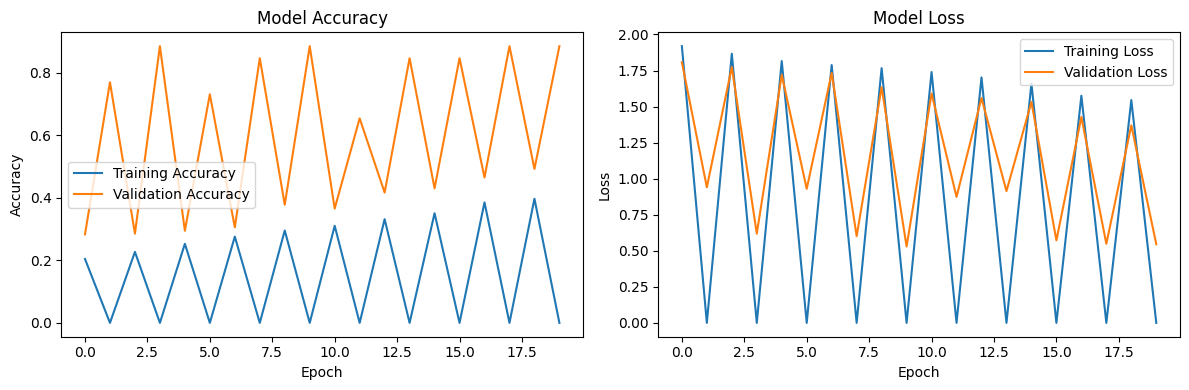

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### model evaluation

In [16]:
# Evaluate the model
test_generator = validation_datagen.flow_from_directory(
    f'{data_dir}/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")

Found 7066 images belonging to 7 classes.
111/111 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - accuracy: 0.3676 - loss: 1.6562
Test accuracy: 0.38
Test loss: 1.63


### Generate predictions

In [17]:
# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

111/111 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step


### Confusion matrix

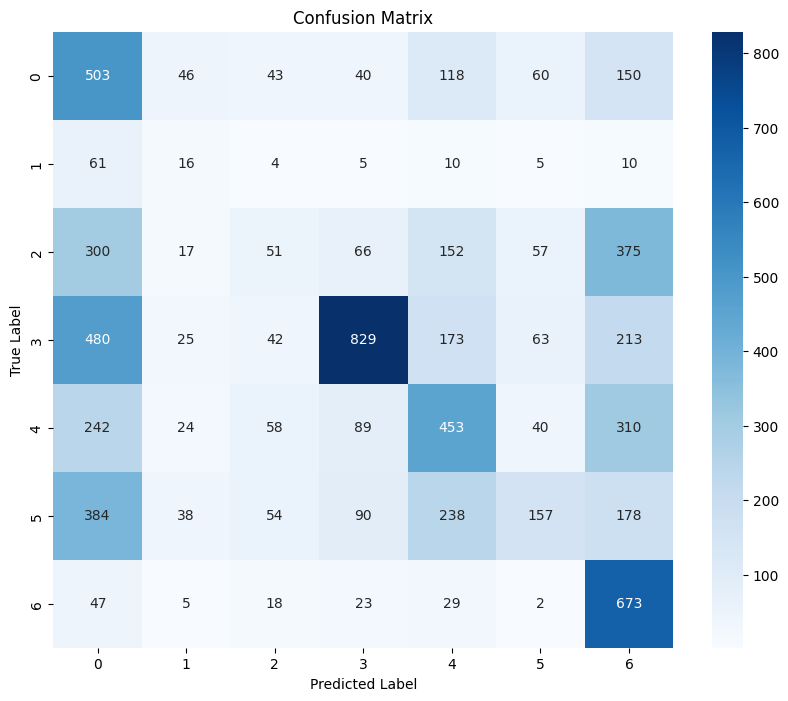

In [18]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Classification report

In [19]:
# Classification report
class_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

       angry       0.25      0.52      0.34       960
     disgust       0.09      0.14      0.11       111
        fear       0.19      0.05      0.08      1018
       happy       0.73      0.45      0.56      1825
     neutral       0.39      0.37      0.38      1216
         sad       0.41      0.14      0.21      1139
    surprise       0.35      0.84      0.50       797

    accuracy                           0.38      7066
   macro avg       0.34      0.36      0.31      7066
weighted avg       0.42      0.38      0.36      7066



### Save the model

In [20]:
# Save the model
model.save('./models/cnn_expression_classification_model.keras')
print("Model saved as 'cnn_expression_classification_model.keras'")

Model saved as 'cnn_expression_classification_model.keras'
